# Imports

In [1]:
from __future__ import annotations
from typing import Tuple, List, Dict, Optional, Any

import numpy as np
import torch
"""import torch.nn as nn
import torch.nn.functional as F"""
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset, DownloadMode

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tqdm

from helper_utils.enum_keys import (
    FPKey,
    DirPath,
    QuantStyle,
    MiscPrompts,
    Contexts,
    Texts,
    ModelKey
)

from PTQ.apply_ptq import applyPTQ
from PTQ.olmo_act_fns import patch_olmo_mlp
import helper_utils.utils as utils

from mech_interp_utils.utils_main.src.transformer_utils import (
    logit_lens,
    activation_lens,
    dictionary_learning,
    chatbot_analysis
)

import warnings
warnings.filterwarnings('ignore')

c:\Users\ampir\anaconda3\envs\MechInterp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
"""import torch._dynamo
torch._dynamo.config.suppress_errors = True"""

In [ ]:
LL_DIR = 'Outputs/Report/LogitLens'
SAE_DIR = 'Outputs/SAE'
MISC_DIR = 'Outputs/Report/Misc'

In [ ]:
filepath = r'D:\ThesisData\wikitext'

destination_path = str(Path(filepath))
dataset = load_dataset(
    'wikitext', 'wikitext-103-raw-v1',
    split={
        'train': 'train[:30%]',
        'validation': 'validation[:10%]',
        'test': 'test[:10%]',
    },
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS,
    keep_in_memory=True
)

In [ ]:
train_texts = dataset['train']

In [ ]:
calibration_texts = [t for t in dataset['train']["text"] if isinstance(t, str) and t.strip()]

In [ ]:
sub_txts = train_texts.take(20)

In [ ]:
#calibration_texts = [t for t in sub_txts["text"] if isinstance(t, str) and t.strip()]

### Params

In [2]:
PARAMS:Dict = {
    'context': Contexts.C1.value,
    'prompt': MiscPrompts.Q11.value,
    'max_new_tokens': 250,
    'temperature': 0.8,
    'repetition_penalty': 1.1,
    'sample': True,
    'device': None
}

# Models and Tokenizer

### Load fp models func

In [3]:
def load_test_model(model_path:str, dtype=torch.dtype) -> AutoModelForCausalLM:
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        return_dict=True,
        output_hidden_states=True,
        torch_dtype=dtype,
        low_cpu_mem_usage=True,
        local_files_only=True,
        use_safetensors=True
    )

    return model

In [4]:
olmo_tokenizer = AutoTokenizer.from_pretrained(FPKey.OLMO1B_TOKENIZER.value)

In [8]:
olmo_fp16 = load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float16)

In [ ]:
olmo_fp16

In [ ]:
olmo_fp16.config

In [5]:
olmo1b_bitnet_fp32 = applyPTQ(
    load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float32),
    tokenizer=olmo_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=PARAMS.get('prompt'),
    mode='1.58bit',
    safer_quant=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=True,
    act_quant=True,
    act_bits=8,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

[INFO] Fragile layers detected (std < 1e-4): []
[INFO] Deactivating act quant for fragile layers:
|| Quant Configs: 1.58bit | BitNet-style PTQ as: PTSQ ||
>> [STEP 1] Wrapping Linear layers (no weight quant yet)...
[SKIP] lm_head | Policy: Skip weight quantization!
>> [STEP 2] Run calibration pass with full-precision weights to collect correct activation stats...
[model.layers.0.self_attn.q_proj] input.mean(): -9.822542779147625e-10, input.std(): 0.9917087554931641
[model.layers.0.self_attn.k_proj] input.mean(): -9.822542779147625e-10, input.std(): 0.9917087554931641
[model.layers.0.self_attn.v_proj] input.mean(): -9.822542779147625e-10, input.std(): 0.9917087554931641
[model.layers.0.self_attn.o_proj] input.mean(): 0.008117463439702988, input.std(): 0.27844682335853577
[model.layers.0.mlp.gate_proj] input.mean(): 1.57160684466362e-09, input.std(): 0.9994108080863953
[model.layers.0.mlp.up_proj] input.mean(): 1.57160684466362e-09, input.std(): 0.9994108080863953
[model.layers.0.mlp.dow

In [6]:
olmo1b_bitnet_fp32

OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoDecoderLayer(
        (self_attn): OlmoAttention(
          (q_proj): BitLinear()
          (k_proj): BitLinear()
          (v_proj): BitLinear()
          (o_proj): BitLinear()
        )
        (mlp): OlmoMLP(
          (gate_proj): BitLinear()
          (up_proj): BitLinear()
          (down_proj): BitLinear()
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
    (rotary_emb): OlmoRotaryEmbedding()
  )
  (lm_head): Linear(in_features=2048, out_features=50304, bias=False)
)

# Activation Lens and Logit Lens

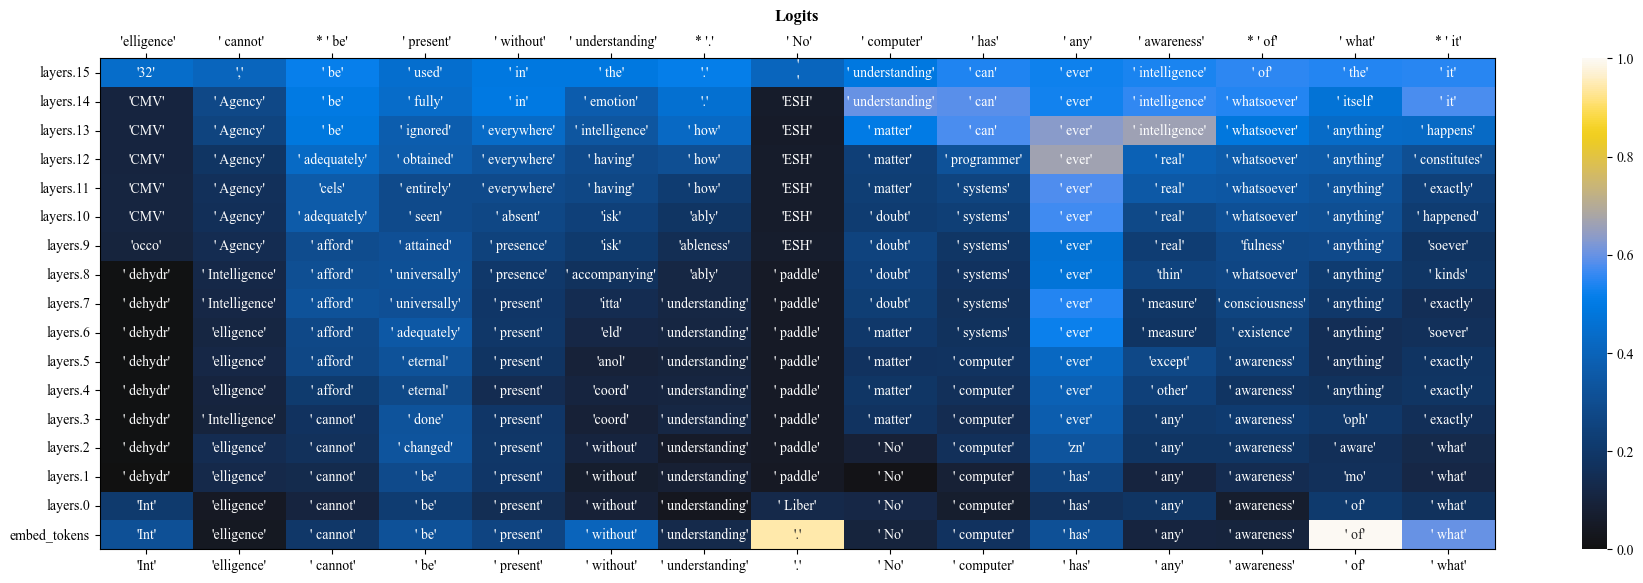

In [9]:
logit_lens.plot_logit_lens(
    model=olmo_fp16,
    tokenizer=olmo_tokenizer,
    input_ids=MiscPrompts.Q11.value,
    start_ix=0, end_ix=15,
    save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/logits_allenai-olmo1b-fp16.jpg',
    #entropy=True,
)

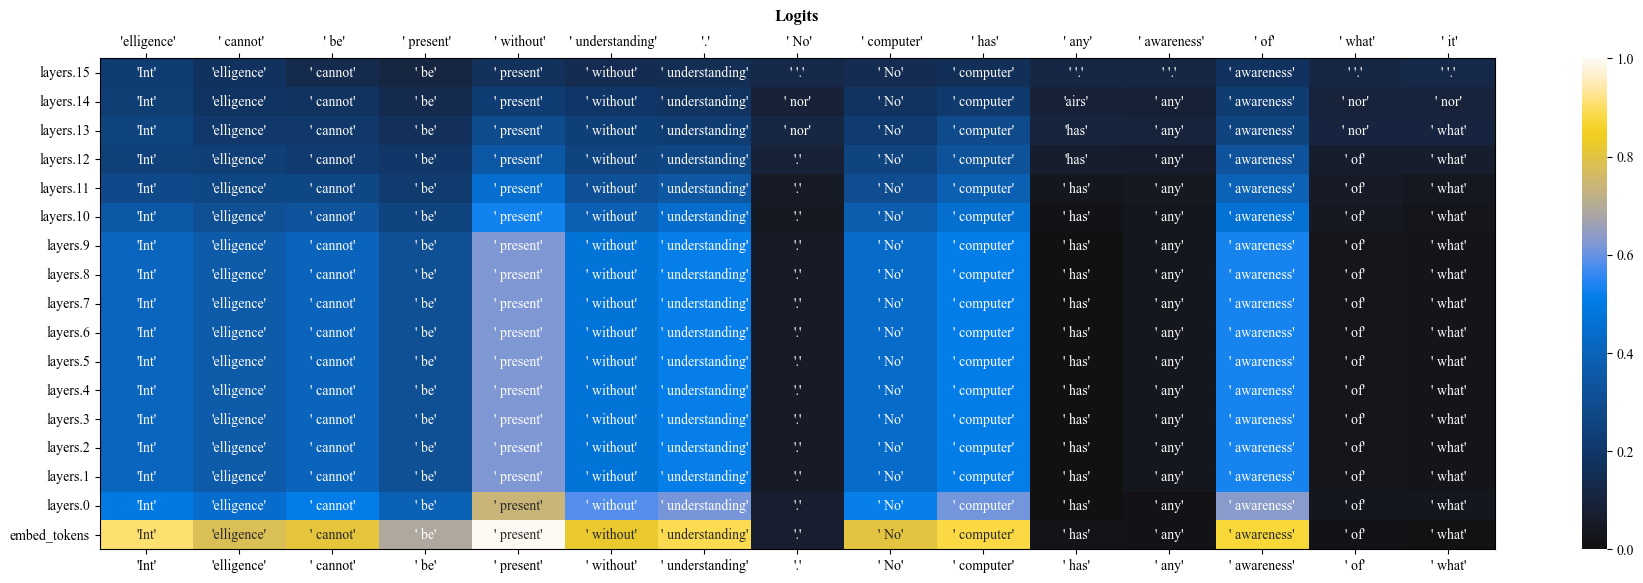

In [7]:
logit_lens.plot_logit_lens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    input_ids=MiscPrompts.Q11.value,
    start_ix=0, end_ix=15,
    save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/logits_allenai-olmo1b-singlecalibration.jpg',
    #entropy=True,
)

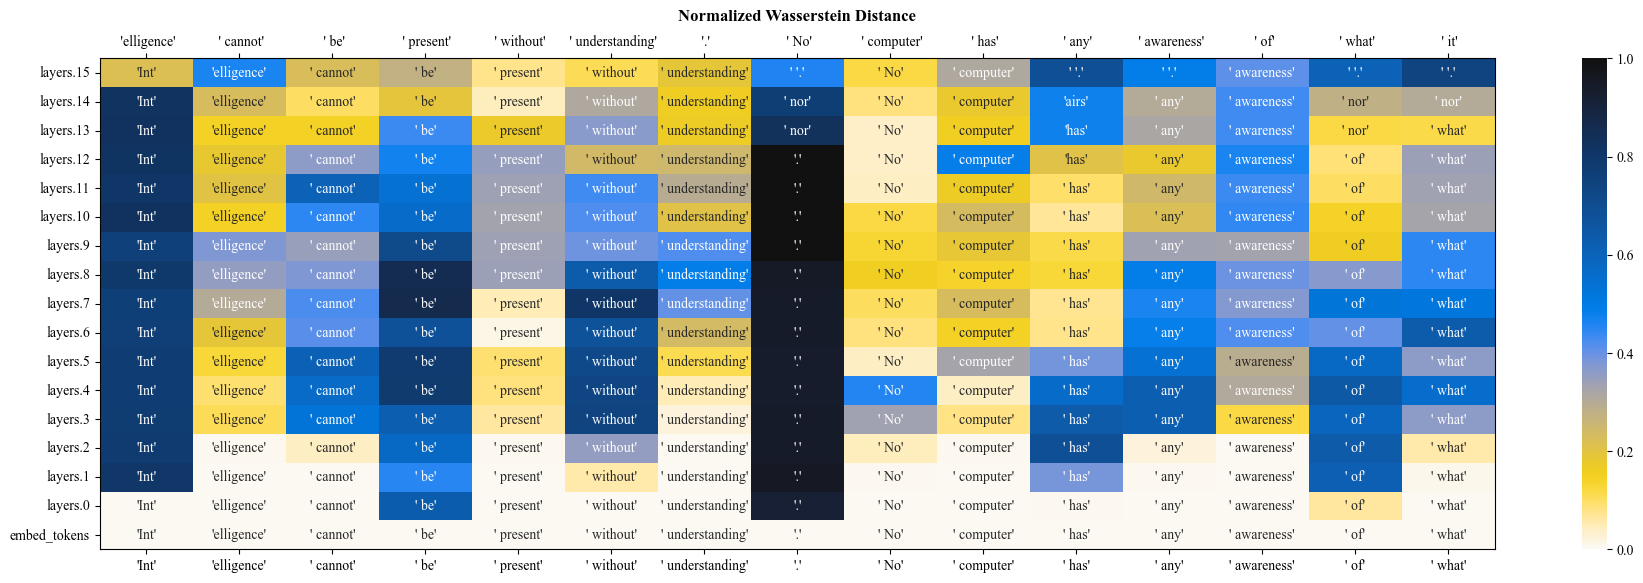

In [10]:
logit_lens.plot_comparing_lens(
    models=(olmo_fp16, olmo1b_bitnet_fp32),
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    #save_fig_path='Outputs/LogitLens/nwd_allenai-olmo1bfp16-ptsq-singlecalibration.jpg',
    save_fig_path=None,
    wasserstein=True,
    #top_down=False,
)

In [ ]:
olmo1b_bitnet_fp32

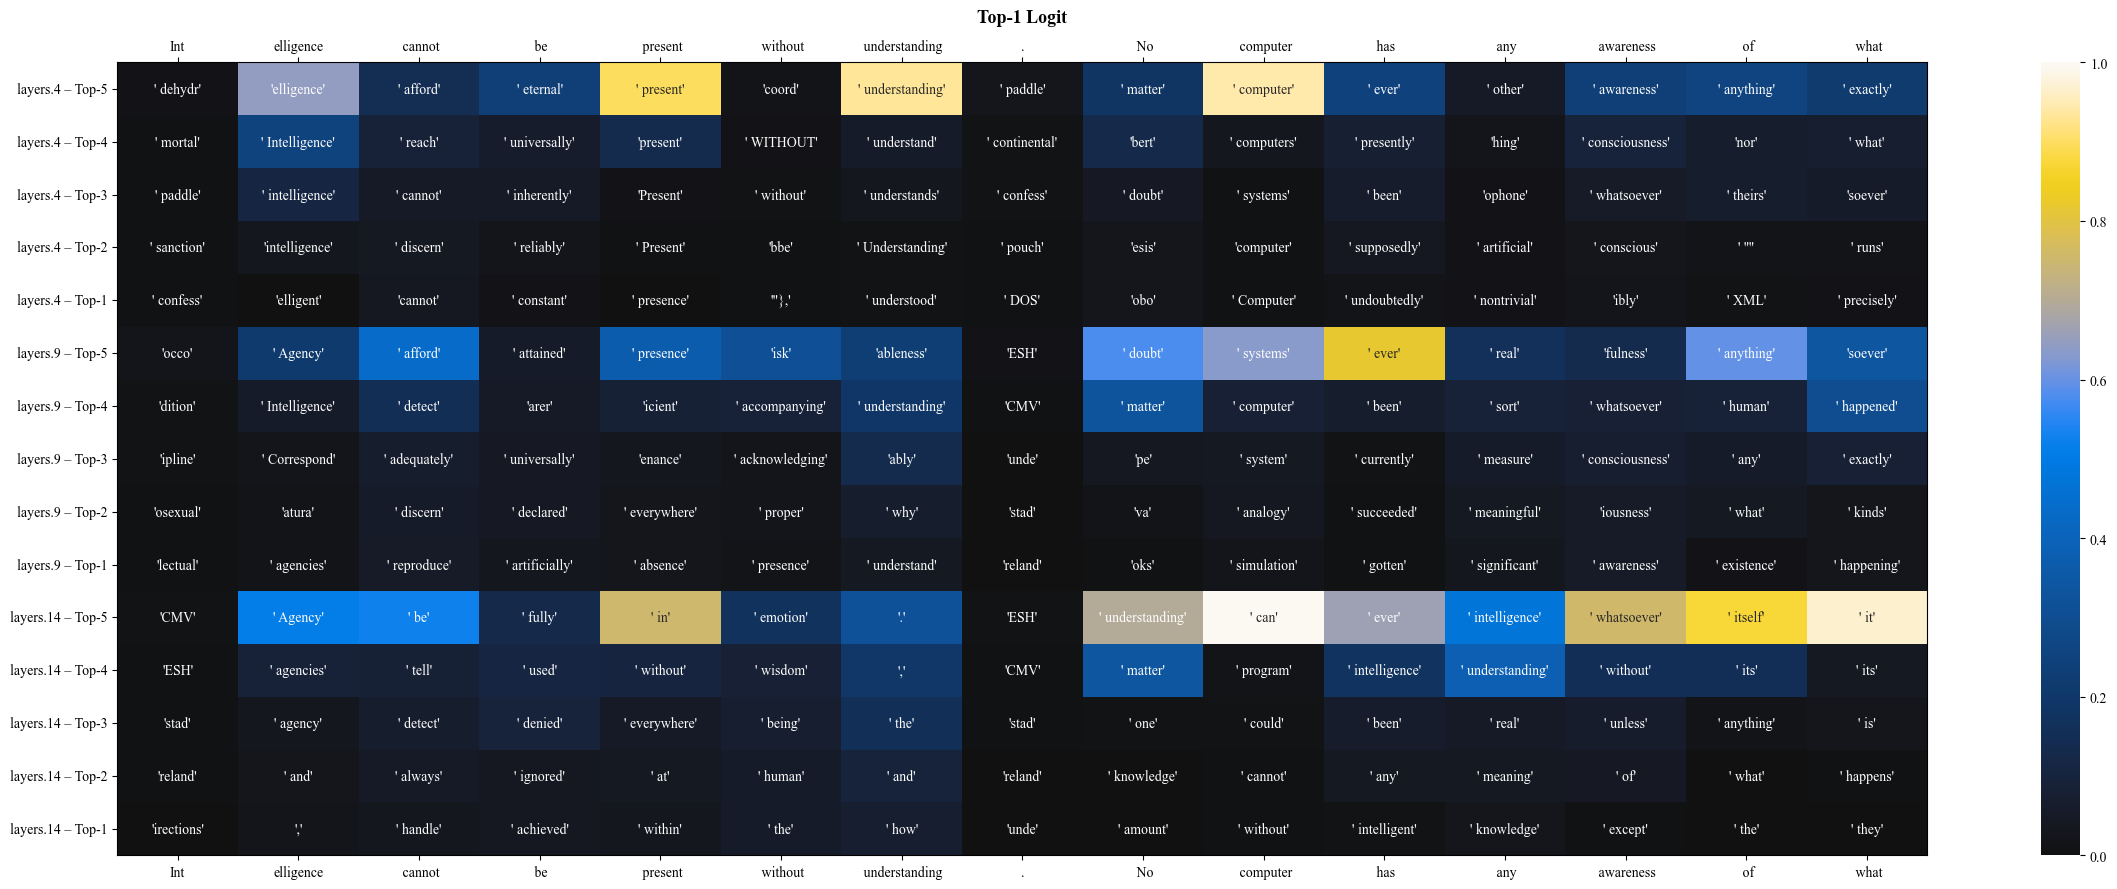

In [11]:
logit_lens.plot_topk_lens(
    model=olmo_fp16,
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    topk_n=5,
    #save_fig_path='Outputs/LogitLens/tokk5-logits_allenai-olmo1b-fp16.jpg'
    save_fig_path=None,
    #entropy=True,
    #top_down=False,
)

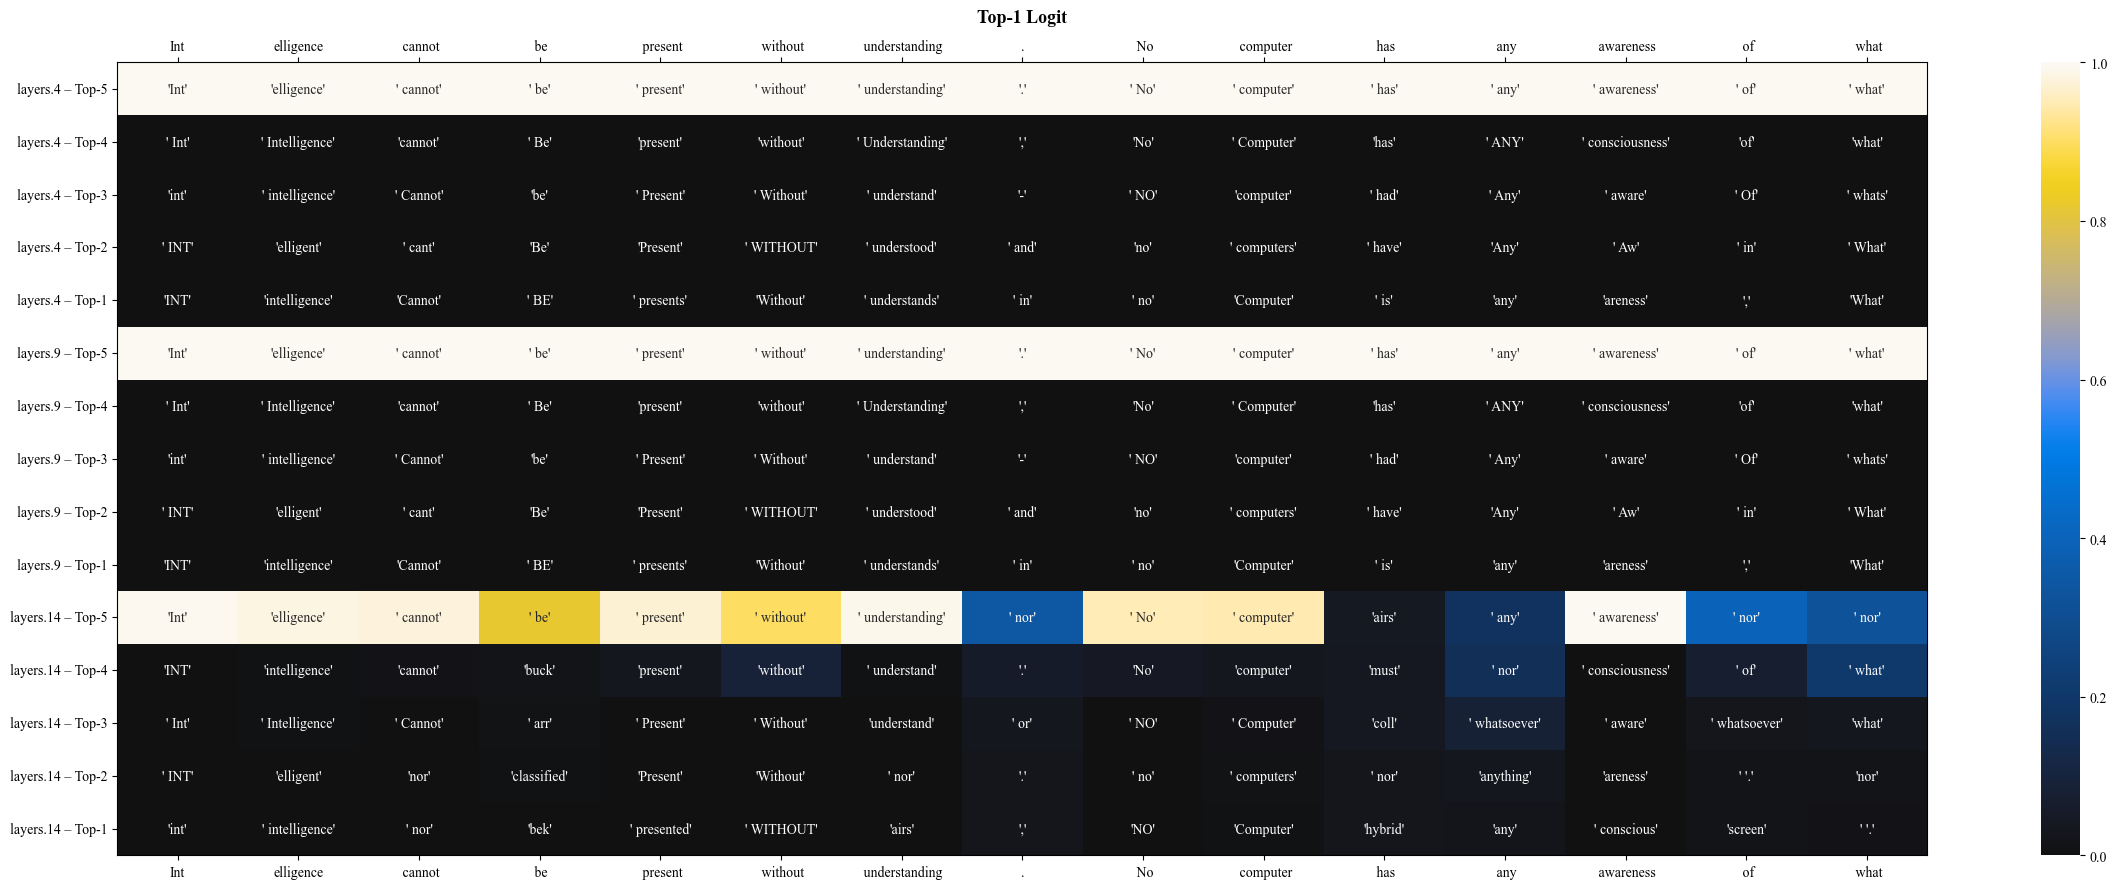

In [12]:
logit_lens.plot_topk_lens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    topk_n=5,
    #save_fig_path='Outputs/LogitLens/topk5-logits_allenai-olmo1b-ptdq.jpg'
    save_fig_path=None,
    #entropy=True,
    #top_down=False,
)

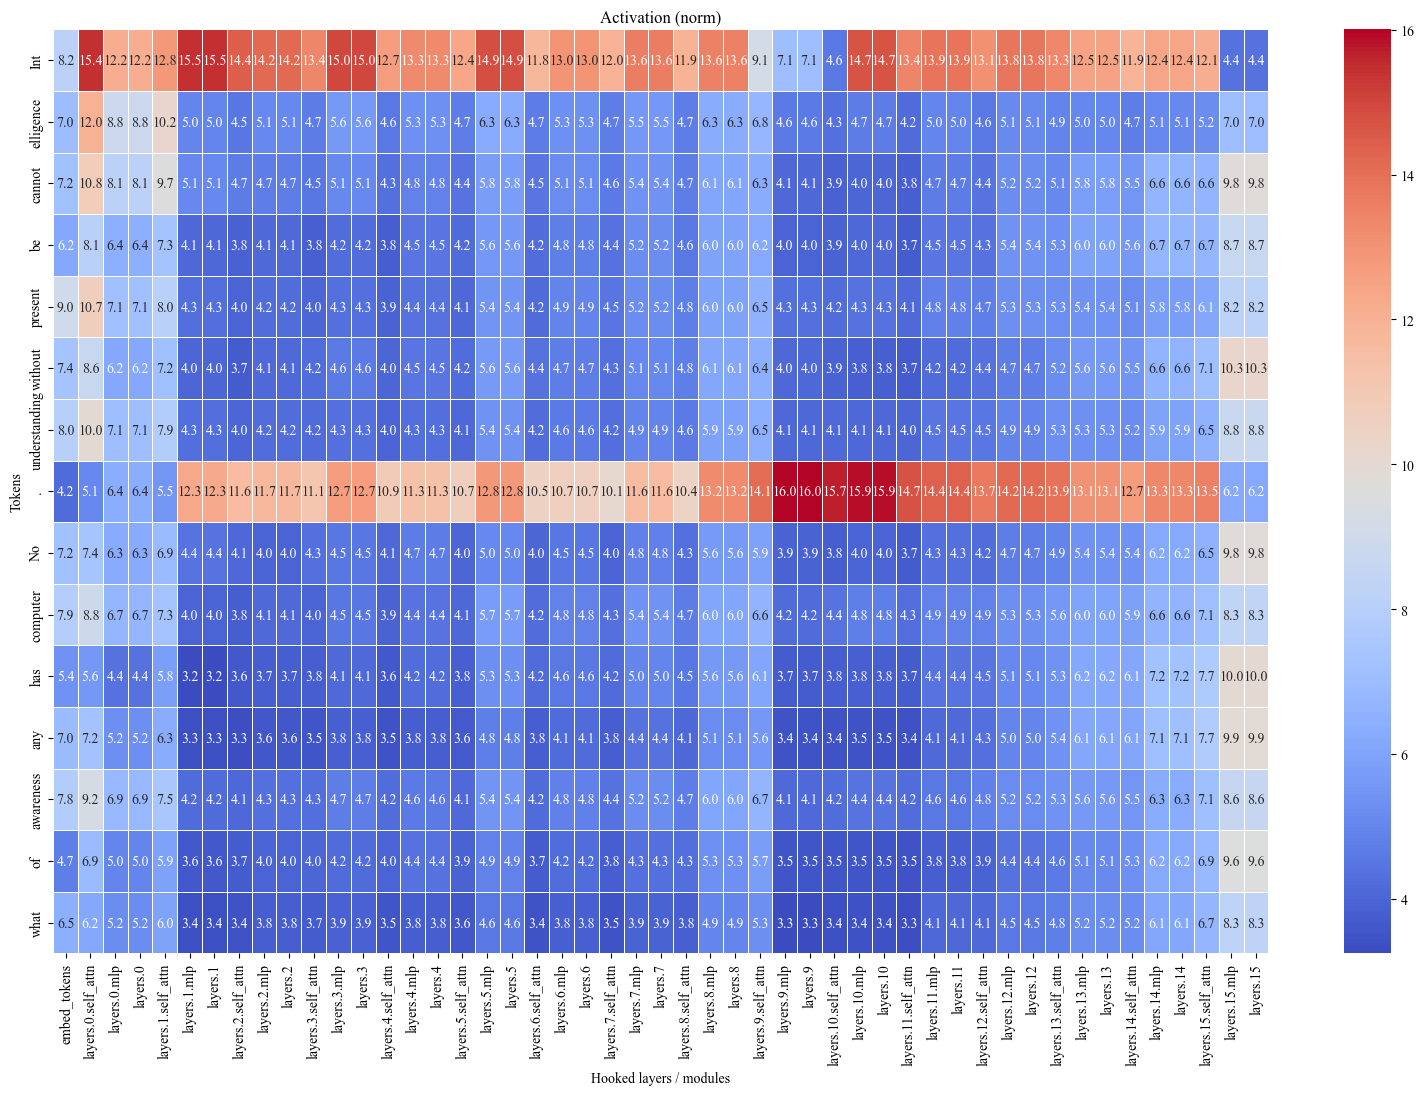

In [13]:
activation_lens.plot_activation_lens(
    model=olmo_fp16,
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    metric='norm',
    #save_fig_path='Outputs/LogitLens/actnorm_allenai-olmo1b-fp16.jpg'
    save_fig_path=None,
)

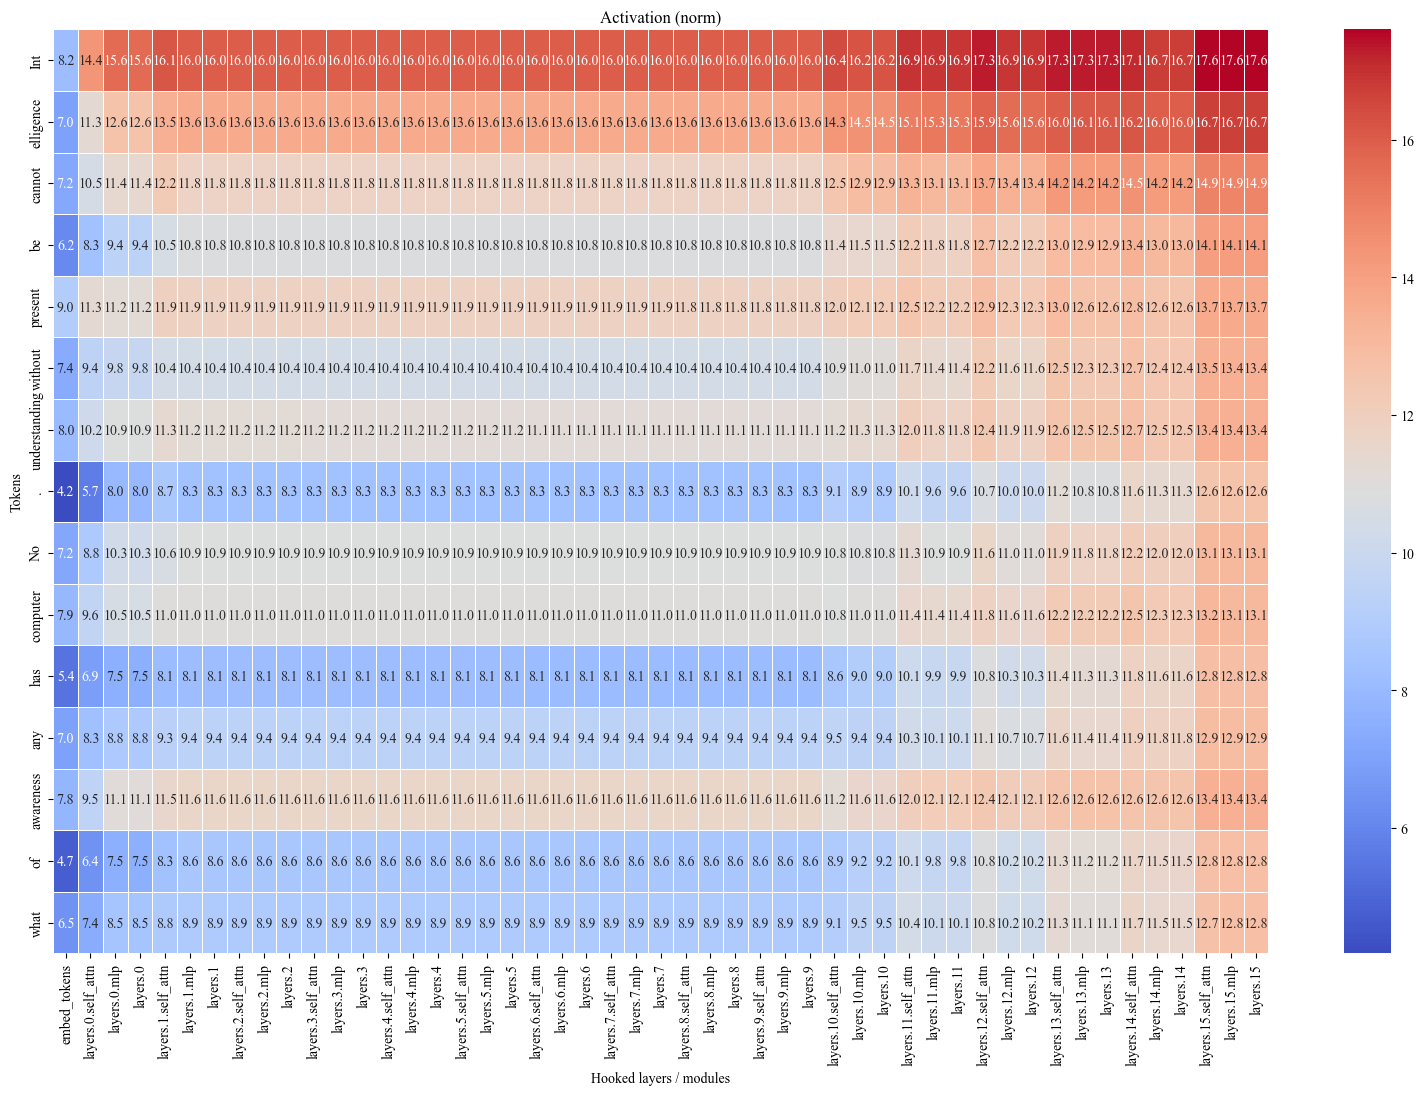

In [14]:
activation_lens.plot_activation_lens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    metric='norm',
    #save_fig_path='Outputs/LogitLens/actnorm_allenai-olmo1b-ptsdq.jpg'
    save_fig_path=None,
)

Shape of diff_vals: (15, 49)
Shape of mask: (15, 49)


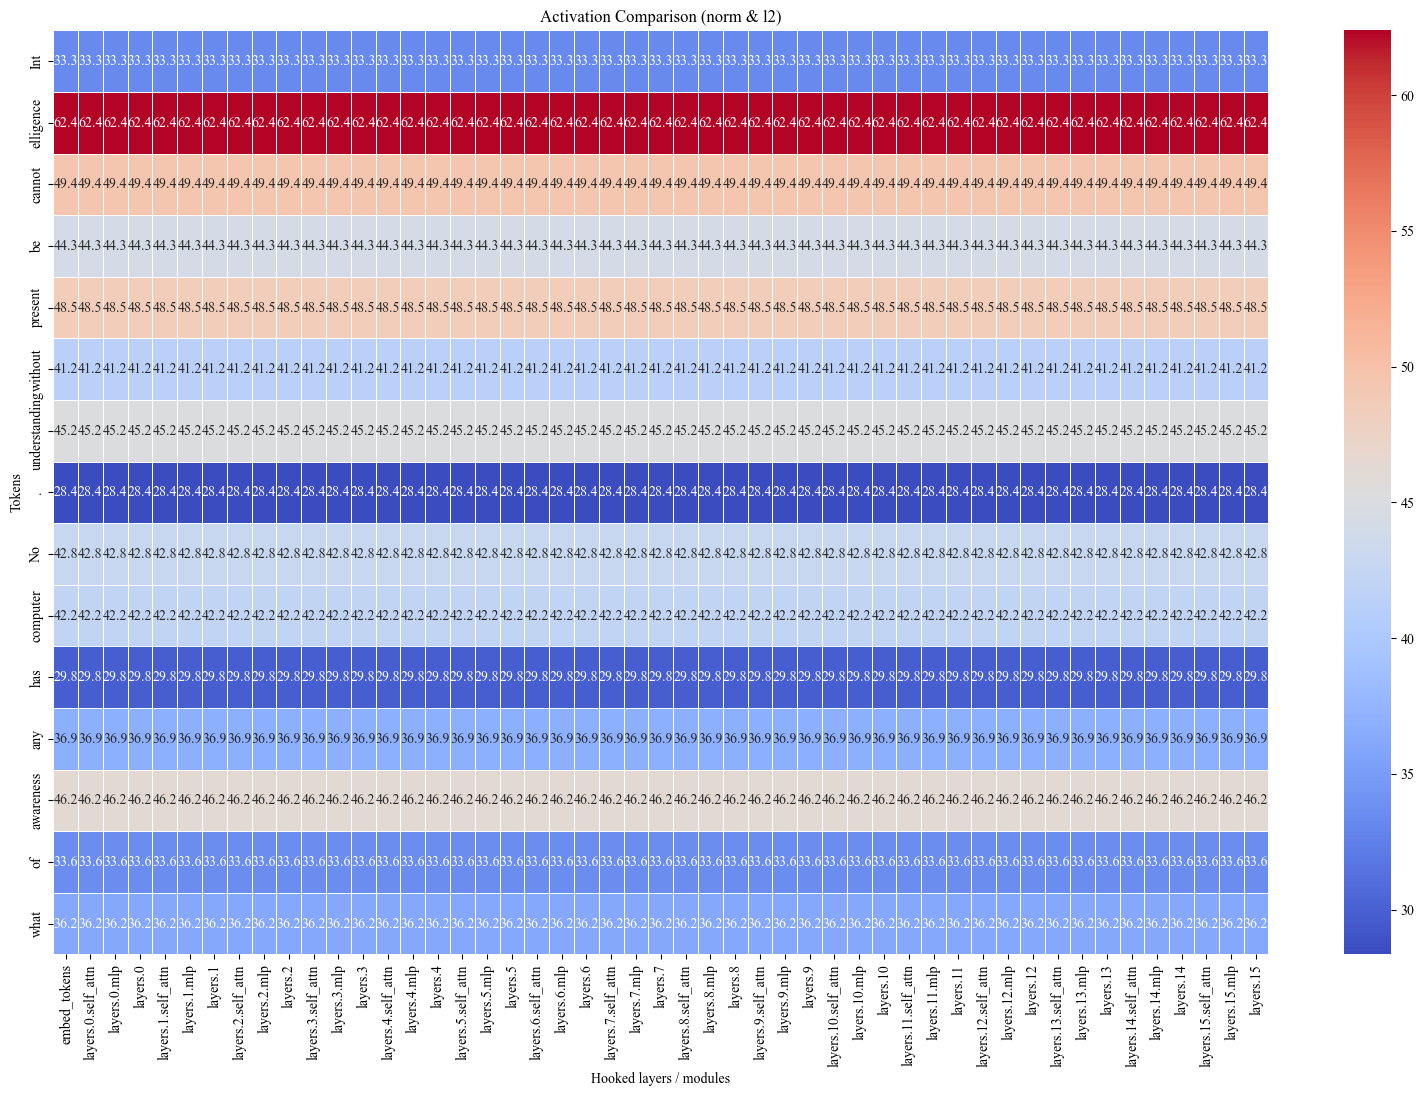

In [15]:
activation_lens.plot_comparing_act_lens(
    models=(olmo_fp16, olmo1b_bitnet_fp32),
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    metric='norm',
    metric_name='l2',
    #save_fig_path='Outputs/LogitLens/actnorml2_allenai-olmo1bfp16-ptdq.jpg'
    save_fig_path=None,
)

# Dictionary Learning: SAE

In [ ]:
dictionary_learning.plot_sae_tokens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    inputs=PARAMS.get('prompt'),
    multi_tokens=False,
    do_log=False,
    target_layers=[5],
    vis_projection=None,
    log_path=None,
    log_name=None,
    fig_path=None
)

In [ ]:
dictionary_learning.plot_sae_tokens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    inputs=PARAMS.get('prompt'),
    multi_tokens=True,
    do_log=False,
    target_layers=[5],
    vis_projection=None,
    log_path=None,
    log_name=None,
    fig_path=None
)

In [ ]:
dictionary_learning.plot_sae_tokens(
    model=olmo_fp16,
    tokenizer=olmo_tokenizer,
    inputs=PARAMS.get('prompt'),
    multi_tokens=True,
    do_log=False,
    target_layers=[5],
    vis_projection=None,
    log_path=None,
    log_name=None,
    fig_path=None
)

In [ ]:
dictionary_learning.plot_sae_heatmap(
    model=olmo_fp16,
    tokenizer=olmo_tokenizer,
    inputs=Texts.T1.value,
    do_log=False,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5],
    log_path=None,
    log_name=None,
    fig_path=None
)

In [ ]:
dictionary_learning.plot_sae_heatmap(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    inputs=Texts.T1.value,
    do_log=False,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5],
    log_path=None,
    log_name=None,
    fig_path=None
)

In [ ]:
dictionary_learning.plot_comparing_heatmap(
    models=(olmo_fp16, olmo1b_bitnet_fp32),
    tokenizer=olmo_tokenizer,
    inputs=Texts.T1.value,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5],
    #fig_path='Outputs/PTQ/sae5_deep3b_fp32_158bit_sym-math.png',
    fig_path=None
)